# Intro:

## Business Problem: Predicting Water Wells In Need Of Repair For The Government Of Tanzania

## Stakeholder: The Ministry Of Water in Tanzania

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [34]:
df_train_target = pd.read_csv('./Data/training_set_labels.csv')
df_train_data = pd.read_csv('./Data/training_set_values.csv')

# Collapsing The Target Categories

The goal is to predict wells that require repair.

The target variable is `status_group` which has three categories:

- `functional`
- `functional needs repair`
- `non functional`

I will collapse the categories `functional needs repair` and `non functional` into one category `needs repair` to create a binary target variable.

In [35]:
# Look at df_train_target
df_train_target['status_group'].value_counts()



functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [36]:
# Change the name of the status_group in df_train_target 'functional needs repair' to 'repair'
# Also change the name of 'non functional' to non-functional
df_train_target['status_group'] = df_train_target['status_group'].replace('functional needs repair', 'repair')
df_train_target['status_group'] = df_train_target['status_group'].replace('non functional', 'repair')

# Check
df_train_target['status_group'].value_counts()

functional    32259
repair        27141
Name: status_group, dtype: int64

In [37]:
# encode status_group as 0, 1
df_train_target['status_group'] = df_train_target['status_group'].astype('category')
df_train_target['status_group'] = df_train_target['status_group'].cat.codes

# Check
df_train_target['status_group'].value_counts(normalize=True)

0    0.543081
1    0.456919
Name: status_group, dtype: float64

So now I have collapsed the target categories, and I have encoded the target variable as a binary variable.

Also note that the target variable is not imbalanced.

In [38]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

# Pipelines:

Time to set up some pipelines.

### Import Statements

In [39]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

### Creating The pipelines

In [40]:
subpipe_numerics = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler())
])


subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

### Creating the column transformer

In [41]:
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include=object))
], remainder='passthrough')

### Dummy Model Pipeline:

In [42]:
dummy_model_pipe = Pipeline(steps=[
    ('ct',CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

### Logreg model pipeline

In [43]:
logreg_model_pipe = Pipeline(steps=[
    ('ct',CT),
    ('fsm', LogisticRegression(max_iter=1000))
])

### Decision Tree

In [44]:
dtc_model_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dtc', DecisionTreeClassifier())
])

# Test, Train, And Validation Split:

I will split the data into three sets:

- train 15%
- validation 15%
- test 70%

In [45]:
# Perform a 15-15-70 split on the data
from sklearn.model_selection import train_test_split

X = df_train_data
y = df_train_target['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)

# Now split again to create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=77)

# Check the shapes
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(35343, 40)
(6237, 40)
(17820, 40)


# Creating The Models

### Dummy Model:

<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

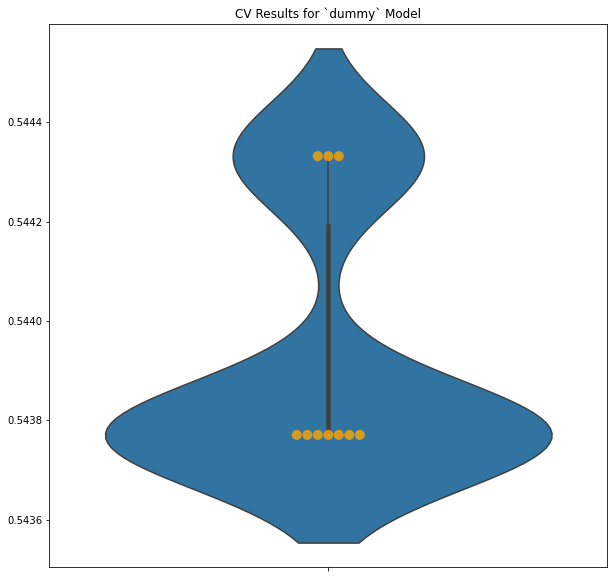

In [ ]:
dummy_pipe = ModelWithCV(
    dummy_model_pipe,
    model_name='dummy',
    X=X_test,
    y=y_test)
fix, ax = plt.subplots(figsize=(10,10))

dummy_pipe.plot_cv(ax=ax)

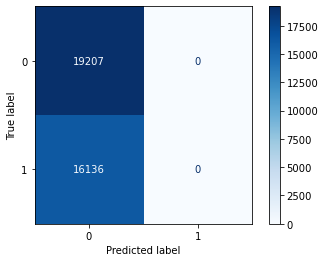

In [ ]:
# confusion matrix
plot_confusion_matrix(dummy_model_pipe, X_train, y_train, cmap='Blues', values_format='d')

In [ ]:
dummy_pipe.print_cv_summary()

CV Results for `dummy` model:
            0.54394 ± 0.00026 accuracy
        


### Logreg Model:

In [49]:
fsm_pipe = ModelWithCV(
    logreg_model_pipe,
    model_name='FSM',
    X=X_test,
    y=y_test)
fix, ax = plt.subplots(figsize=(10,10))

fsm_pipe.plot_cv(ax=ax)

In [ ]:
Check model metrics
print('Logistic Regression Model')
print('Training Accuracy: ', logreg_model_pipe.score(X_train, y_train))
print('Validation Accuracy: ', logreg_model_pipe.score(X_val, y_val))
print('Test Accuracy: ', logreg_model_pipe.score(X_test, y_test))
print('Training Recall: ', recall_score(y_train, logreg_model_pipe.predict(X_train)))
print('Validation Recall: ', recall_score(y_val, logreg_model_pipe.predict(X_val)))
print('Test Recall: ', recall_score(y_test, logreg_model_pipe.predict(X_test)))
print('Training Precision: ', precision_score(y_train, logreg_model_pipe.predict(X_train)))
print('Validation Precision: ', precision_score(y_val, logreg_model_pipe.predict(X_val)))
print('Test Precision: ', precision_score(y_test, logreg_model_pipe.predict(X_test)))
print('Training F1: ', f1_score(y_train, logreg_model_pipe.predict(X_train)))
print('Validation F1: ', f1_score(y_val, logreg_model_pipe.predict(X_val)))
print('Test F1: ', f1_score(y_test, logreg_model_pipe.predict(X_test)))

# Check the confusion matrix
plot_confusion_matrix(logreg_model_pipe, X_val, y_val, cmap='Blues', values_format='d');

In [ ]:
fsm_pipe.print_cv_summary()

AttributeError: 'Pipeline' object has no attribute 'print_cv_summary'

### Decision Tree Model:

In [ ]:
dtc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002BF10D3CBE0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

<AxesSubplot:title={'center':'CV Results for `dtc` Model'}>

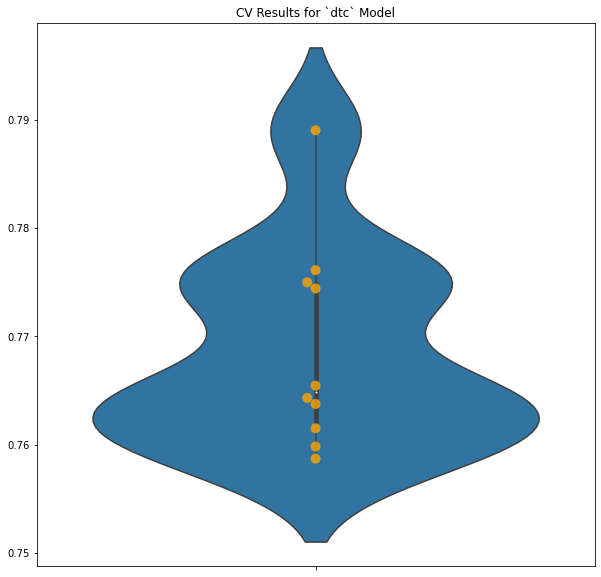

In [ ]:
dtc_pipe = ModelWithCV(
    dtc_model_pipe,
    model_name='dtc',
    X=X_test,
    y=y_test)
fix, ax = plt.subplots(figsize=(10,10))

dtc_pipe.plot_cv(ax=ax)

In [ ]:
# What is the score on the train and test data?
print('score on training data ', dtc_model_pipe.score(X_train, y_train))
print('score on test data ', dtc_model_pipe.score(X_test, y_test))

score on training data  1.0
score on test data  0.7928731762065095


In [47]:
dtc_pipe.print_cv_summary()

CV Results for `dtc` model:
            0.76880 ± 0.00908 accuracy
        


# Now let's start improving the models. 